In [ ]:
import tensorflow as tf

In [5]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_nn = x_train.astype('float32') / 255.0
x_test_nn = x_test.astype('float32') / 255.0
y_train_nn = tf.keras.utils.to_categorical(y_train, 10)
y_test_nn = tf.keras.utils.to_categorical(y_test, 10)

In [31]:
def make_dense_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.categorical_crossentropy, metrics=[tf.metrics.categorical_accuracy])
    return model

In [38]:
def make_cnn_small_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.categorical_crossentropy, metrics=[tf.metrics.categorical_accuracy])
    return model

In [39]:
def make_cnn_big_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.categorical_crossentropy, metrics=[tf.metrics.categorical_accuracy])
    return model

In [ ]:
def train(models: list[tf.keras.Model]):
    histories = []
    for model in models:
        model.build((None, 28, 28, 1))
        history = model.fit(x_train_nn, y_train_nn, epochs=5, batch_size=64, validation_data=(x_test_nn, y_test_nn))
        histories.append(history)
    return histories

In [ ]:
def save(models: list[tf.keras.Model]):
    for i in range(len(models)):
        models[i].save(f"model-{i}.keras")

In [45]:
from matplotlib import pyplot as plt
from typing import Any, List, Dict, Union, Optional

HistoryLike = Union[Dict[str, List[float]], Any]


def _detect_accuracy_keys(history: Dict[str, List[float]]):
    candidate_val = next((k for k in history.keys() if k.startswith('val_') and ('acc' in k or 'accuracy' in k)), None)
    if candidate_val:
        train_key = candidate_val[len('val_'):]
        val_key = candidate_val
        if train_key not in history:
            train_key = next((k for k in history.keys() if ('acc' in k or 'accuracy' in k) and not k.startswith('val_')), None)
    else:
        train_key = next((k for k in history.keys() if ('acc' in k or 'accuracy' in k) and not k.startswith('val_')), None)
        val_key = ('val_' + train_key) if train_key and ('val_' + train_key) in history else None
        if not val_key:
            val_key = next((k for k in history.keys() if k.startswith('val_') and ('acc' in k or 'accuracy' in k)), None)
    return train_key, val_key


def plot_histories(histories: list[HistoryLike],
                    model_names: Optional[List[str]] = None,
                    show_train: bool = True,
                    show_val: bool = True,
                    figsize=(10, 6)):
    dicts = []
    for h in histories:
        if hasattr(h, "history"):
            dicts.append(h.history)
        elif isinstance(h, dict):
            dicts.append(h)
        else:
            raise TypeError(f"Unsupported history type: {type(h)}")

    if model_names is None:
        model_names = [f"model-{i}" for i in range(len(dicts))]
    if len(model_names) != len(dicts):
        raise ValueError("`model_names` length must match number of histories.")

    fig, ax = plt.subplots(figsize=figsize)
    for i, hist in enumerate(dicts):
        train_key, val_key = _detect_accuracy_keys(hist)
        name = model_names[i]
        epochs = range(1, max((len(v) for v in hist.values()), default=0) + 1)
        if show_train and train_key and train_key in hist:
            ax.plot(range(1, len(hist[train_key]) + 1), hist[train_key],
                    label=f"{name} train ({train_key})", linestyle='-', marker=None)
        if show_val and val_key and val_key in hist:
            ax.plot(range(1, len(hist[val_key]) + 1), hist[val_key],
                    label=f"{name} val ({val_key})", linestyle='--', marker=None)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Training and Validation Accuracy")
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='best', fontsize='small')
    plt.tight_layout()
    return fig, ax


In [41]:
models = [make_dense_model(), make_cnn_small_model(), make_cnn_big_model()]

In [ ]:
output = train(models)

In [ ]:
save(models)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>)

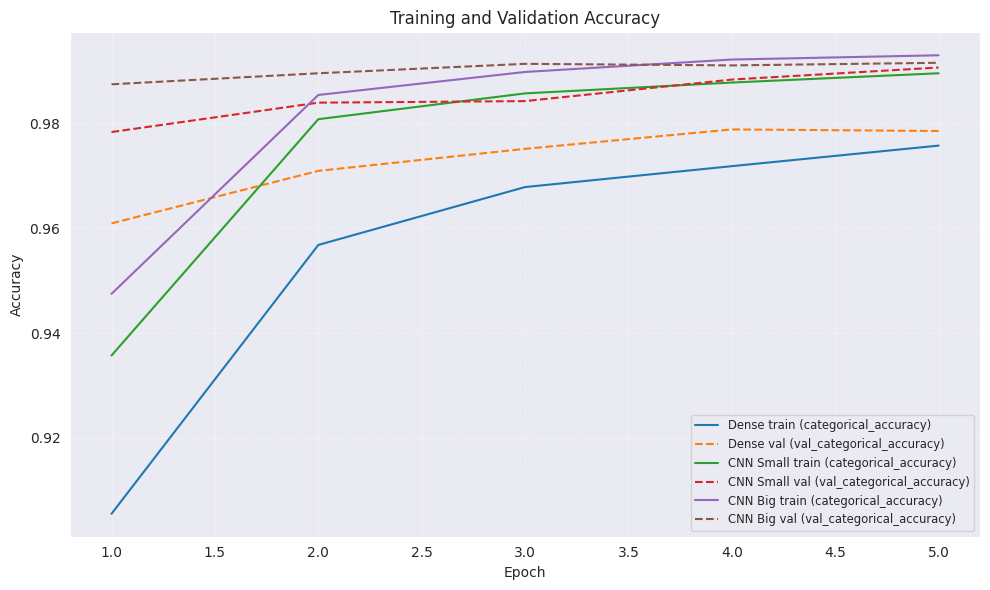

In [47]:
plot_histories(output, ["Dense", "CNN Small", "CNN Big"])